In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mltools as ml
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
np.random.seed(1)

#sklearn
from sklearn import mixture
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.metrics import recall_score

In [4]:
diab = pd.read_csv("dataset_diabetes/diabetic_data.csv")
ord_enc = OrdinalEncoder()

In [5]:
for column_name in diab.columns:
    print(diab[column_name].value_counts())

2278392      1
190792044    1
190790070    1
190789722    1
190786806    1
            ..
106665324    1
106657776    1
106644876    1
106644474    1
443867222    1
Name: encounter_id, Length: 101766, dtype: int64
88785891     40
43140906     28
1660293      23
88227540     23
23199021     23
             ..
11005362      1
98252496      1
1019673       1
13396320      1
175429310     1
Name: patient_nbr, Length: 71518, dtype: int64
Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64
Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64
[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64
?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-1

In [6]:
# remove columns with high amounts of unknown, "?", values and all unique values
diab = diab.drop(columns=['encounter_id', 
                          'weight',
                          'payer_code',
                          'medical_specialty']) 
print("Duplicates by patient_nbr:",diab.duplicated(subset=['patient_nbr']).value_counts()[1])
diab = diab.drop_duplicates(subset=['patient_nbr'])
diabnzv = diab
diabnzv = ord_enc.fit_transform(diabnzv)
var_thr = VarianceThreshold(threshold = 0.10) 
# remove columns with low variance
var_thr.fit(diabnzv)

concol = [column for column in diab.columns 
          if column not in diab.columns[var_thr.get_support()]]

# for features in concol:
#     print(features) # Uncomment to see which columns/features dropped for low variance
    
diab = diab.drop(concol,axis=1)
print("Samples left:",diab.shape[0],"\nFeatures left:",diab.shape[1])

Duplicates by patient_nbr: 30248
Samples left: 71518 
Features left: 26


In [7]:
diabnp = diab.to_numpy()
diabnp = ord_enc.fit_transform(diabnp)
diabprocess = pd.DataFrame(diabnp, columns = diab.columns)
print("Samples:",diab.shape[0],"\nFeatures:",diab.shape[1])
print(diabprocess.info())

Samples: 71518 
Features: 26
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71518 entries, 0 to 71517
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   patient_nbr               71518 non-null  float64
 1   race                      71518 non-null  float64
 2   gender                    71518 non-null  float64
 3   age                       71518 non-null  float64
 4   admission_type_id         71518 non-null  float64
 5   discharge_disposition_id  71518 non-null  float64
 6   admission_source_id       71518 non-null  float64
 7   time_in_hospital          71518 non-null  float64
 8   num_lab_procedures        71518 non-null  float64
 9   num_procedures            71518 non-null  float64
 10  num_medications           71518 non-null  float64
 11  number_outpatient         71518 non-null  float64
 12  number_emergency          71518 non-null  float64
 13  number_inpatient          71518 

In [8]:
# Turn target feature to binary. Only run once
diabprocess.readmitted[diabprocess.readmitted == 1.0] = 0.0
diabprocess.readmitted[diabprocess.readmitted == 2.0] = 1.0
print(diabprocess.readmitted)

0        1.0
1        0.0
2        1.0
3        1.0
4        1.0
        ... 
71513    0.0
71514    0.0
71515    0.0
71516    1.0
71517    1.0
Name: readmitted, Length: 71518, dtype: float64


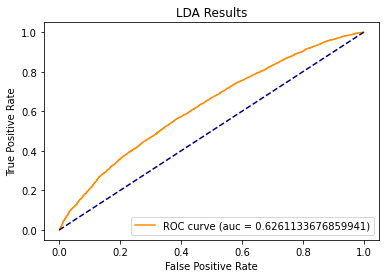

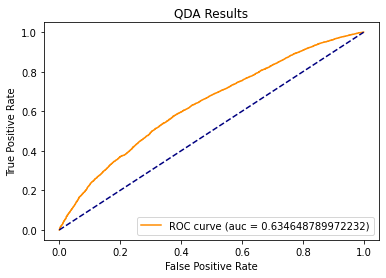

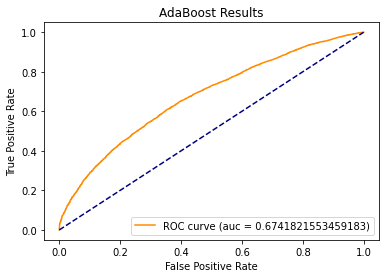

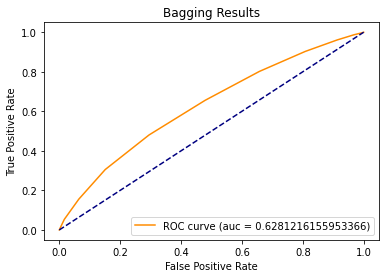

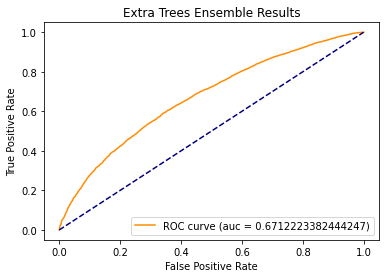

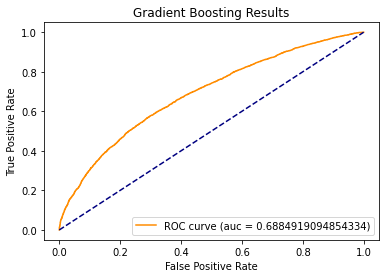

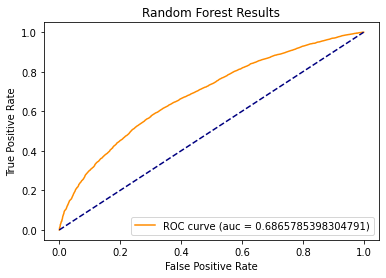

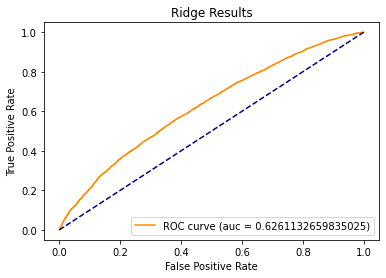

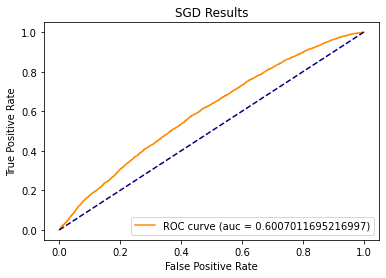

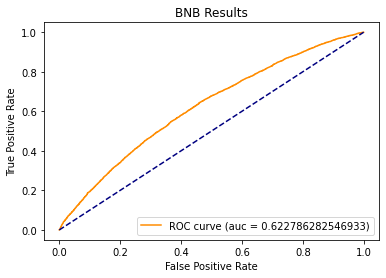

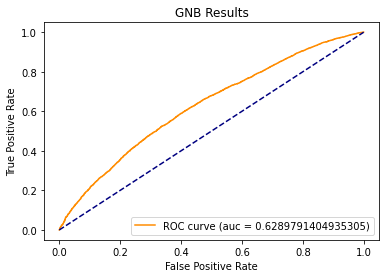

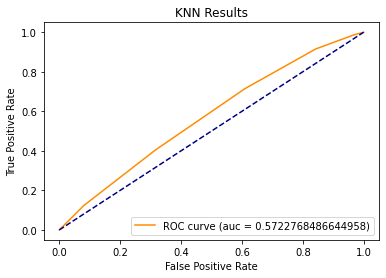

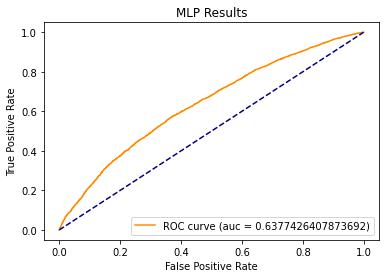

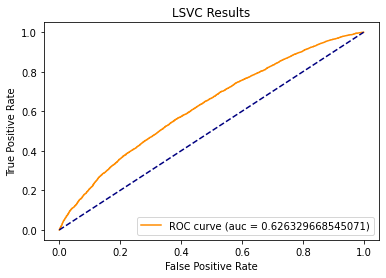

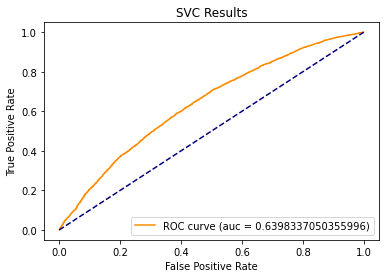

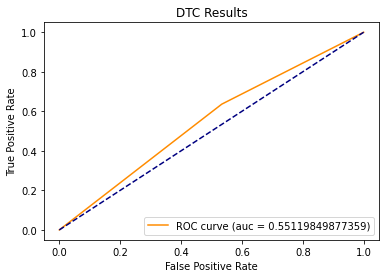

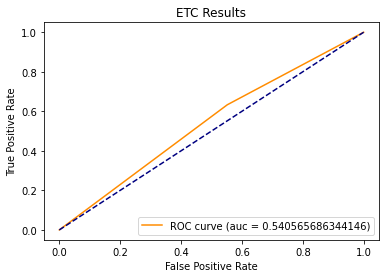

Best model is Gradient Boosting


In [9]:
y = diabprocess['readmitted']
X = diabprocess.drop('readmitted', axis=1)

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

models = []
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('AdaBoost', AdaBoostClassifier()))
models.append(('Bagging', BaggingClassifier()))
models.append(('Extra Trees Ensemble', ExtraTreesClassifier(n_estimators=1000)))
models.append(('Gradient Boosting', GradientBoostingClassifier()))
models.append(('Random Forest', RandomForestClassifier(n_estimators=1000)))
models.append(('Ridge', RidgeClassifier()))
models.append(('SGD', SGDClassifier(tol=1e-3, max_iter=10000)))
models.append(('BNB', BernoulliNB()))
models.append(('GNB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('MLP', MLPClassifier()))
models.append(('LSVC', LinearSVC(max_iter=100000)))
# models.append(('NuSVC', NuSVC(gamma='scale')))
models.append(('SVC', SVC(gamma='scale')))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('ETC', ExtraTreeClassifier()))

DECISION_FUNCTIONS = {"Ridge", "SGD", "LSVC", "NuSVC", "SVC"}
from sklearn.metrics import roc_auc_score, roc_curve
%matplotlib inline

best_model = None
best_model_name = ""
best_valid = 0
for name, model in models:
    model.fit(X_train, y_train)
    if name in DECISION_FUNCTIONS:
        proba = model.decision_function(X_valid)
    else:
        proba = model.predict_proba(X_valid)[:,1]
    score = roc_auc_score(y_valid, proba,multi_class="ovo")
    fpr, tpr, _  = roc_curve(y_valid, proba)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f"ROC curve (auc = {score})")
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.title(f"{name} Results")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()
    if score > best_valid:
        best_valid = score
        best_model = model
        best_model_name = name

print(f"Best model is {best_model_name}")

In [13]:
Xtr, Xte, Ytr, Yte = train_test_split(X,y,test_size=.3, random_state= 0)
gbc = GradientBoostingClassifier().fit(Xtr, Ytr)
print(gbc.score(Xte,Yte))
rf = RandomForestClassifier().fit(Xtr,Ytr)
print(rf.score(Xte,Yte))

0.6509134973900075
0.6468120805369127


KeyError: 'weight'

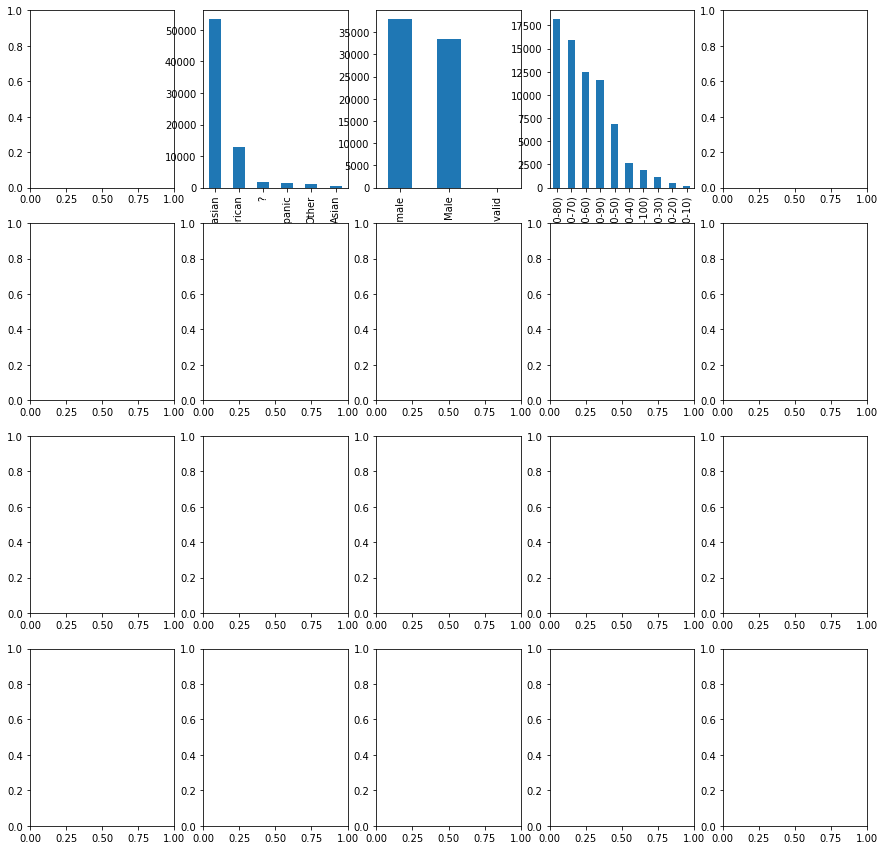

In [11]:
fig, axs = plt.subplots(4,5,figsize=(15,15))
# 'encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
# 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
# 'time_in_hospital', 'payer_code', 'medical_specialty',
# 'num_lab_procedures', 'num_procedures', 'num_medications',
# 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
# 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
# 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
# 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
# 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
# 'tolazamide', 'examide', 'citoglipton', 'insulin',
# 'glyburide-metformin', 'glipizide-metformin',
# 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
# 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'

# diab['patient_nbr'].value_counts().plot(kind="bar",ax=axs[0,0])
diab['race'].value_counts().plot(kind="bar",ax=axs[0,1])
diab['gender'].value_counts().plot(kind="bar",ax=axs[0,2])
diab['age'].value_counts().plot(kind="bar",ax=axs[0,3])
diab['weight'].value_counts().plot(kind="bar",ax=axs[0,4])

diab['admission_type_id'].value_counts().plot(kind="bar",ax=axs[1,0])
diab['discharge_disposition_id'].value_counts().plot(kind="bar",ax=axs[1,1])
diab['admission_source_id'].value_counts().plot(kind="bar",ax=axs[1,2])
diab['time_in_hospital'].value_counts().plot(kind="bar",ax=axs[1,3])
diab['payer_code'].value_counts().plot(kind="bar",ax=axs[1,4])

diab['medical_specialty'].value_counts().plot(kind="bar",ax=axs[2,0])
diab['num_lab_procedures'].value_counts().plot(kind="bar",ax=axs[2,1])
diab['num_procedures'].value_counts().plot(kind="bar",ax=axs[2,2])
diab['num_medications'].value_counts().plot(kind="bar",ax=axs[2,3])
diab['number_outpatient'].value_counts().plot(kind="bar",ax=axs[2,4])

diab['number_emergency'].value_counts().plot(kind="bar",ax=axs[3,0])
diab['number_inpatient'].value_counts().plot(kind="bar",ax=axs[3,1])
diab['diag_1'].value_counts().plot(kind="bar",ax=axs[3,2])
diab['diag_2'].value_counts().plot(kind="bar",ax=axs[3,3])
diab['diag_3'].value_counts().plot(kind="bar",ax=axs[3,4])

# diab['medical_specialty'].value_counts().plot(kind="bar",ax=axs[4,0])
# diab['num_lab_procedures'].value_counts().plot(kind="bar",ax=axs[4,1])
# diab['num_procedures'].value_counts().plot(kind="bar",ax=axs[4,2])
# diab['num_medications'].value_counts().plot(kind="bar",ax=axs[4,3])
# diab['number_outpatient'].value_counts().plot(kind="bar",ax=axs[4,4])
plt.show()

In [ ]:
diabnp = diab.to_numpy()
Y = diabnp[:,-1]
X = diabnp[:,1:-1]
Yc = np.unique(Y)
Ycolors = []
for i in Y:
    if i == Yc[0]:
        Ycolors.append(0) # <30
    elif i == Yc[1]:
        Ycolors.append(0) # >30
    elif i == Yc[2]:
        Ycolors.append(1) # NO
# print(Yc)
# print(Ycolors)
# for i in range(len(X)-1):
#     plt.scatter(X[:,i],X[:,i+1])
#     plt.show()

##  [1] "max_glu_serum"            "repaglinide"             
##  [3] "nateglinide"              "chlorpropamide"          
##  [5] "glimepiride"              "acetohexamide"           
##  [7] "tolbutamide"              "acarbose"                
##  [9] "miglitol"                 "troglitazone"            
## [11] "tolazamide"               "examide"                 
## [13] "citoglipton"              "glyburide.metformin"     
## [15] "glipizide.metformin"      "glimepiride.pioglitazone"
## [17] "metformin.rosiglitazone"  "metformin.pioglitazone"      